In [187]:
import yfinance as yf
import numpy as np
import pandas as pd
import arch
import matplotlib.pyplot as plt

In [188]:
ticker = "^GSPC"
data = yf.download(ticker, start="1962-01-02", end="2023-01-01")

C:\Users\jdobe\AppData\Local\Temp\ipykernel_21352\2274404261.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [189]:
print(data.head())
print(data.shape)

Price           Close       High        Low       Open   Volume
Ticker          ^GSPC      ^GSPC      ^GSPC      ^GSPC    ^GSPC
Date                                                           
1962-01-02  70.959999  71.959999  70.709999  71.550003  3120000
1962-01-03  71.129997  71.480003  70.379997  70.959999  3590000
1962-01-04  70.639999  71.620003  70.449997  71.129997  4450000
1962-01-05  69.660004  70.839996  69.349998  70.639999  4630000
1962-01-08  69.120003  69.839996  68.169998  69.660004  4620000
(15356, 5)


In [190]:
# Create variable Log Returns and further
data["DailyReturn"] = np.log(data["Close"]).diff()
data['Sign_1d'] = (data['DailyReturn'] > 0).astype(int)
data['Volume_change'] = np.log(data['Volume']).diff()
data['Trading_range'] = np.log(data['High'] / data['Low'])

data = data.iloc[1:]

In [191]:
model = arch.arch_model(data["DailyReturn"]*1000, vol="GARCH", p=1, q=1)
model_fit = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 780727851372.1755
Iteration:      2,   Func. Count:     14,   Neg. LLF: 18031389.150344383
Iteration:      3,   Func. Count:     21,   Neg. LLF: 54663.01721751453
Iteration:      4,   Func. Count:     27,   Neg. LLF: 54549.42168044949
Iteration:      5,   Func. Count:     33,   Neg. LLF: 56596.042303034905
Iteration:      6,   Func. Count:     39,   Neg. LLF: 54588.092763351
Iteration:      7,   Func. Count:     45,   Neg. LLF: 54518.354737768575
Iteration:      8,   Func. Count:     51,   Neg. LLF: 54565.79750354307
Iteration:      9,   Func. Count:     57,   Neg. LLF: 54511.77134661394
Iteration:     10,   Func. Count:     62,   Neg. LLF: 54511.761345715364
Iteration:     11,   Func. Count:     67,   Neg. LLF: 54511.76129966311
Iteration:     12,   Func. Count:     72,   Neg. LLF: 54511.7612991028
Optimization terminated successfully    (Exit mode 0)
            Current function value: 54511.7612991028
            Iterations: 12
 

# Deep Learning

In [192]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import random
from sklearn.preprocessing import StandardScaler

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [193]:
NUMBER_OF_LAGS = 20  # number of lagged observations
TRAIN_SIZE = 5000
HIDDEN_DIM = 16
NUM_LAYERS = 1
DROPOUT = 0.0
BATCH_SIZE = 5000
NUMBER_OF_EPOCHS = 50
CLASSIFICATION_THRESHOLD = 0.5

TODO: Add more variables

10 Year US Treasury Bills (Ticker: ^TNX)

In [194]:
interest_rates = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
# merge Close price of interest rates with main data
data = data.merge(interest_rates[["Close"]], left_index=True, right_index=True, how="left", suffixes=('', '_TNX'))
data.rename(columns={"Close": "10y_treasury_bills"}, inplace=True)

C:\Users\jdobe\AppData\Local\Temp\ipykernel_21352\763790586.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  interest_rates = yf.download("^TNX", start="1962-01-02", end="2023-01-01")
[*********************100%***********************]  1 of 1 completed


In [195]:
# Add lagged returns as features
data['Lag1'] = data['DailyReturn'].shift(1)
data['GARCH_volatility'] = model_fit.conditional_volatility

data = data.dropna()

# Feature matrix: inv_vol + lagged returns
features = np.column_stack([
    data['GARCH_volatility'].values,
    data['Lag1'].values,
    data['Volume_change'].values,
    data['Trading_range'].values,
    data['10y_treasury_bills'].values
])

input_variables = features.shape[1]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Currently, the past returns and inverse volatility are used for predicting the next return. This might not be economically sensible as many people believe returns are independent and form a martingale difference sequence (MDS). 

In [196]:
features

array([[ 5.68052228e+00,  2.39282503e-03,  2.14751894e-01,
         1.64712079e-02,  7.06399994e+01,  3.99000001e+00],
       [ 5.93868951e+00, -6.91260248e-03,  3.96527719e-02,
         2.12576365e-02,  6.96600037e+01,  4.01999998e+00],
       [ 7.27679593e+00, -1.39702301e-02, -2.16216300e-03,
         2.42023006e-02,  6.91200027e+01,  4.03000021e+00],
       ...,
       [ 1.20964653e+01, -4.05784403e-03,  1.74101770e-02,
         1.77063619e-02,  3.78321997e+03,  3.88700008e+00],
       [ 1.21473612e+01, -1.20934704e-02, -2.62335980e-02,
         1.37639095e-02,  3.84928003e+03,  3.83500004e+00],
       [ 1.26780394e+01,  1.73106343e-02, -7.95852819e-03,
         1.03427692e-02,  3.83950000e+03,  3.87899995e+00]],
      shape=(15233, 6))

By using StandardScaler, each variable will be standard normally distributed.

In [197]:
# Create lagged feature matrix for LSTM
def create_lagged_matrix_multifeature(X, window):
    out = []
    for i in range(window, len(X)):
        out.append(X[i-window:i, :])
    return np.array(out)

X_lagged = create_lagged_matrix_multifeature(features_scaled, NUMBER_OF_LAGS)
y_target = data['Sign_1d'].values[NUMBER_OF_LAGS:]

In [198]:
# Split train/test
X_train = X_lagged[:TRAIN_SIZE]
y_train = y_target[:TRAIN_SIZE]
X_test = X_lagged[TRAIN_SIZE:]
y_test = y_target[TRAIN_SIZE:]

# Convert to torch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

## Define LSTM Model

In [199]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, num_layers=1, dropout=0.0):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.0)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        return self.sigmoid(out)

model = SimpleLSTM(input_dim=input_variables, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS, dropout=DROPOUT)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [200]:
model

SimpleLSTM(
  (lstm): LSTM(6, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Model Training

X_train_t contains batch size, sequence length (number of lags) and number of variables.
Pytorch automatically calls forward()-method when input is given to the model.

In [201]:
train_dataset = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(NUMBER_OF_EPOCHS):     # number of seeing the training data for learning parameters
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4f}")

Epoch 0: loss = 0.6926
Epoch 10: loss = 0.6907
Epoch 20: loss = 0.6872
Epoch 30: loss = 0.6833
Epoch 40: loss = 0.6766


### Out of sample Prediction

In [202]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_pred_sign = (y_pred_test > CLASSIFICATION_THRESHOLD).astype(int)

# --- Results ---
results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_sign,
    'Probability': y_pred_test
}, index=data.index[NUMBER_OF_LAGS+TRAIN_SIZE:])

In [203]:
from sklearn.metrics import classification_report, accuracy_score

# Classification report
print("Classification Report:")
print(classification_report(results['Actual'], results['Predicted']))
print("Accuracy:", accuracy_score(results['Actual'], results['Predicted']))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.16      0.24      4762
           1       0.53      0.84      0.65      5451

    accuracy                           0.52     10213
   macro avg       0.50      0.50      0.45     10213
weighted avg       0.50      0.52      0.46     10213

Accuracy: 0.5237442475276608


Text(0.5, 1.0, 'Predicted Probability of Positive Return')

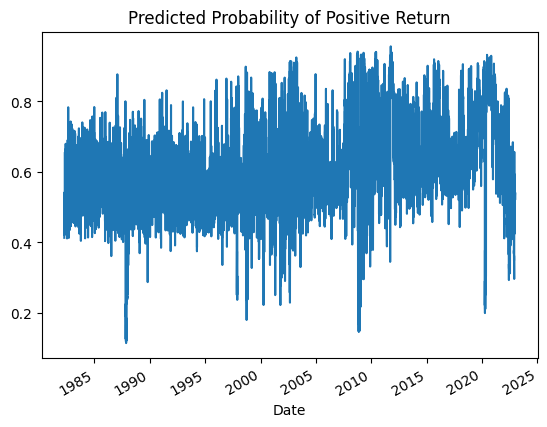

In [204]:
results["Probability"].plot()
plt.title("Predicted Probability of Positive Return")
#plt.ylim(0, 1)